# Vlasov-Poisson 

 We consider the dimensionless Vlasov-Poisson equation for one species
 with a neutralizing background.

$$
 \frac{∂f}{∂t}+ v⋅∇_x f + E(t,x) ⋅ ∇_v f = 0, \\
 - Δϕ = 1 - ρ, E = - ∇ ϕ \\
 ρ(t,x)  =  ∫ f(t,x,v)dv.
$$

 - [Vlasov Equation - Wikipedia](https://en.wikipedia.org/wiki/Vlasov_equation)
 - [Landau damping - Wikipedia](https://en.wikipedia.org/wiki/Landau_damping)


In [7]:
using Plots, LinearAlgebra
pyplot()

Plots.PyPlotBackend()

In [8]:
using Splittings

In [9]:
function push_x!(
        f::Array{Complex{Float64},2}, 
        p::Int64, 
        meshx::UniformMesh, 
        v::Vector{Float64}, 
        nv::Int64, 
        dt::Float64)
    
    advection!(f, p, meshx, v, nv, dt)
    
end

push_x! (generic function with 1 method)

In [10]:
function push_v!(
        f::Array{Complex{Float64},2}, 
        fᵗ::Array{Complex{Float64},2}, 
        p::Int64, 
        meshx::UniformMesh, 
        meshv::UniformMesh, 
        ρ::Vector{Complex{Float64}}, 
        e::Vector{Complex{Float64}}, 
        nx::Int64, 
        dt::Float64)
    
    compute_rho!(ρ, meshv, f)
    compute_e!(e, meshx, ρ)
    transpose!(fᵗ, f)
    advection!(fᵗ, p, meshv, real(e), nx, dt)
    transpose!(f, fᵗ)
    
end  

push_v! (generic function with 1 method)

In [11]:
function landau(tf::Float64, nt::Int64)

  p = 5 # spline degree
  nx, nv = 128, 256
  meshx = UniformMesh( 0.0,  4π, nx; endpoint=false)
  meshv = UniformMesh(-6.0, 6.0, nv; endpoint=false)
  x = meshx.x
  v = meshv.x
  dx = meshx.dx

  α, kx = 0.001, 0.5
  f  = zeros(Complex{Float64},(nx,nv))
  f .= (1.0.+ α * cos.(kx*x))/sqrt(2π) * transpose(exp.(-0.5*v.^2))
  fᵗ = zeros(Complex{Float64},(nv,nx))
  e  = zeros(Complex{Float64}, nx)
  ρ  = zeros(Complex{Float64}, nx)

  dt = tf / nt

  nrj = Float64[]

  for it in 1:nt
        
      @TripleJump(
          push_x!(f, p, meshx, v, nv, dt),
          push_v!(f, fᵗ, p, meshx, meshv, ρ, e, nx, dt)
      )       
      push!(nrj, 0.5*log(sum(real(e).*real(e))*dx))
  end

  nrj

end

landau (generic function with 1 method)

 15.130863 seconds (1.54 M allocations: 1.887 GiB, 1.73% gc time)


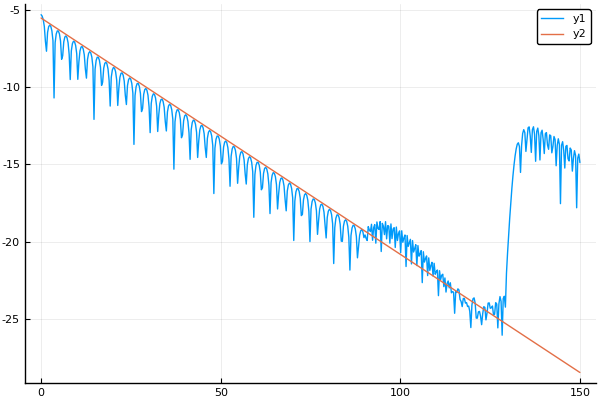

In [12]:
nt = 500
tf = 150.0
t  = range(0.0, stop=tf, length=nt)
@time nrj = landau(tf, nt)
plot( t, nrj)
plot!(t, -0.1533*t.-5.50)